# VUS Prediction from ClinVar Germline Variants
## EDA & Data Preprocessing

### Pipeline Overview
1. Load VEP-annotated ClinVar data
2. Map clinical significance labels
3. Separate VUS from labeled training data (VUS = inference target, not a training class)
4. EDA on labeled (Pathogenic/Benign) variants
5. Feature engineering (applied identically to labeled + VUS sets)
6. Train/test split by variant ID using `GroupShuffleSplit` — prevents transcript-level leakage
7. Save checkpoints for model training

> Design decision: All transcript-level annotations are retained (not filtered to canonical only).
> This preserves richer biological context (splice effects in non-canonical transcripts, BIOTYPE signals, etc.).
> To prevent data leakage, the train/test split is done by variant ID (`Uploaded_variation`),
> ensuring all transcripts of a variant stay within the same split.
>
> The model is trained as a binary classifier (Pathogenic vs Benign).
> VUS variants are held out and predicted at inference time.
> Final per-variant predictions are obtained by aggregating probabilities across transcripts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

df_raw = pd.read_csv("vep_cleaned.tsv", sep="\t", low_memory=False)
print("Raw shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

Raw shape: (3965133, 79)
Columns: ['Uploaded_variation', 'Location', 'Allele', 'Gene', 'Feature', 'Feature_type', 'Consequence', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation', 'IMPACT', 'DISTANCE', 'STRAND', 'FLAGS', 'VARIANT_CLASS', 'SYMBOL', 'SYMBOL_SOURCE', 'HGNC_ID', 'BIOTYPE', 'CANONICAL', 'MANE', 'MANE_SELECT', 'MANE_PLUS_CLINICAL', 'TSL', 'APPRIS', 'CCDS', 'ENSP', 'SWISSPROT', 'TREMBL', 'UNIPARC', 'UNIPROT_ISOFORM', 'GENE_PHENO', 'SIFT', 'PolyPhen', 'EXON', 'INTRON', 'DOMAINS', 'miRNA', 'AF', 'AFR_AF', 'AMR_AF', 'EAS_AF', 'EUR_AF', 'SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF', 'gnomADe_ASJ_AF', 'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_MID_AF', 'gnomADe_NFE_AF', 'gnomADe_REMAINING_AF', 'gnomADe_SAS_AF', 'gnomADg_AF', 'gnomADg_AFR_AF', 'gnomADg_AMI_AF', 'gnomADg_AMR_AF', 'gnomADg_ASJ_AF', 'gnomADg_EAS_AF', 'gnomADg_FIN_AF', 'gnomADg_MID_AF', 'gnomADg_NFE_AF', 'gnomADg_REMAINING_AF', 'gnomADg_SAS_AF', 'MAX_AF', 

## Step 1 — Label Mapping & Separation of VUS

ClinVar `CLIN_SIG` values are mapped to three clean categories:
- Pathogenic: pathogenic + likely_pathogenic
- Benign: benign + likely_benign
- VUS: uncertain_significance

Conflicting or mixed interpretations are excluded.

>  VUS variants are not used as a training class. They are separated into `df_vus`
> and will only be used at inference time to receive a predicted pathogenicity probability.

In [2]:
# Remove rows with no clinical label
df = df_raw[df_raw['CLIN_SIG'] != '-'].copy()
print(f"After removing unlabeled rows: {len(df):,}")
print(f"Total transcript-level rows retained: {len(df):,}")

def map_clnsig(value):
    val = str(value).lower().strip()

    # Drop conflicting interpretations
    if 'conflicting' in val:
        return None

    has_path        = 'pathogenic' in val
    has_likely_path = 'likely_pathogenic' in val
    has_benign      = 'benign' in val
    has_likely_ben  = 'likely_benign' in val
    has_vus         = 'uncertain_significance' in val

    # Drop mixed pathogenic + benign signals
    if (has_path or has_likely_path) and (has_benign or has_likely_ben):
        return None

    if has_path or has_likely_path:
        return 'Pathogenic'
    elif has_benign or has_likely_ben:
        return 'Benign'
    elif has_vus:
        return 'VUS'
    else:
        return None  # risk_factor, drug_response, not_provided, etc.

df['label'] = df['CLIN_SIG'].apply(map_clnsig)

print("\nFull label distribution (before split):")
print(df['label'].value_counts(dropna=False))

# VUS are NOT a training class. They are held out for inference.
df_vus     = df[df['label'] == 'VUS'].copy().reset_index(drop=True)
df_labeled = df[df['label'].isin(['Pathogenic', 'Benign'])].copy().reset_index(drop=True)

print(f"\nLabeled (training) transcript rows : {len(df_labeled):,}")
print(f"  Pathogenic : {(df_labeled['label'] == 'Pathogenic').sum():,}")
print(f"  Benign     : {(df_labeled['label'] == 'Benign').sum():,}")
print(f"  Unique variants (labeled) : {df_labeled['Uploaded_variation'].nunique():,}")
print(f"\nVUS (inference only) transcript rows : {len(df_vus):,}")
print(f"  Unique VUS variants : {df_vus['Uploaded_variation'].nunique():,}")

After removing unlabeled rows: 2,426,333
Total transcript-level rows retained: 2,426,333

Full label distribution (before split):
label
VUS           1456325
Benign         527651
Pathogenic     406548
None            35809
Name: count, dtype: int64

Labeled (training) transcript rows : 934,199
  Pathogenic : 406,548
  Benign     : 527,651
  Unique variants (labeled) : 35,998

VUS (inference only) transcript rows : 1,456,325
  Unique VUS variants : 58,249


## Step 2 — EDA on Labeled Variants (Pathogenic vs Benign)

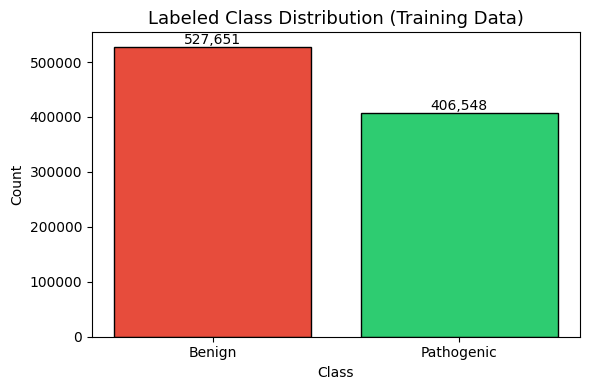

Class proportions:
label
Benign        0.565
Pathogenic    0.435
Name: proportion, dtype: float64


In [3]:
# Class distribution
fig, ax = plt.subplots(figsize=(6, 4))
counts = df_labeled['label'].value_counts()
bars = ax.bar(counts.index, counts.values,
              color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_title('Labeled Class Distribution (Training Data)', fontsize=13)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
for bar in bars:
    ax.annotate(f'{int(bar.get_height()):,}',
                (bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('01_class_distribution.png', dpi=150)
plt.show()

print("Class proportions:")
print(df_labeled['label'].value_counts(normalize=True).round(3))

In [4]:
# SIFT & PolyPhen EDA (before imputation)
df_labeled['SIFT_score_eda']    = df_labeled['SIFT'].str.extract(r'\(([\d\.]+)\)').astype(float)
df_labeled['PolyPhen_score_eda']= df_labeled['PolyPhen'].str.extract(r'\(([\d\.]+)\)').astype(float)

print("SIFT missing:   ", df_labeled['SIFT_score_eda'].isna().sum(),
      f"({df_labeled['SIFT_score_eda'].isna().mean()*100:.1f}%)")
print("PolyPhen missing:", df_labeled['PolyPhen_score_eda'].isna().sum(),
      f"({df_labeled['PolyPhen_score_eda'].isna().mean()*100:.1f}%)")

print("\nSIFT stats by class (non-missing only):")
print(df_labeled.groupby('label')['SIFT_score_eda'].describe().round(3))

print("\nPolyPhen stats by class (non-missing only):")
print(df_labeled.groupby('label')['PolyPhen_score_eda'].describe().round(3))

SIFT missing:    662932 (71.0%)
PolyPhen missing: 715465 (76.6%)

SIFT stats by class (non-missing only):
               count   mean    std  min   25%   50%   75%  max
label                                                         
Benign      223467.0  0.184  0.277  0.0  0.01  0.06  0.22  1.0
Pathogenic   47800.0  0.012  0.063  0.0  0.00  0.00  0.00  1.0

PolyPhen stats by class (non-missing only):
               count   mean    std  min    25%    50%    75%  max
label                                                            
Benign      185091.0  0.317  0.370  0.0  0.009  0.110  0.639  1.0
Pathogenic   33643.0  0.738  0.358  0.0  0.514  0.957  0.998  1.0


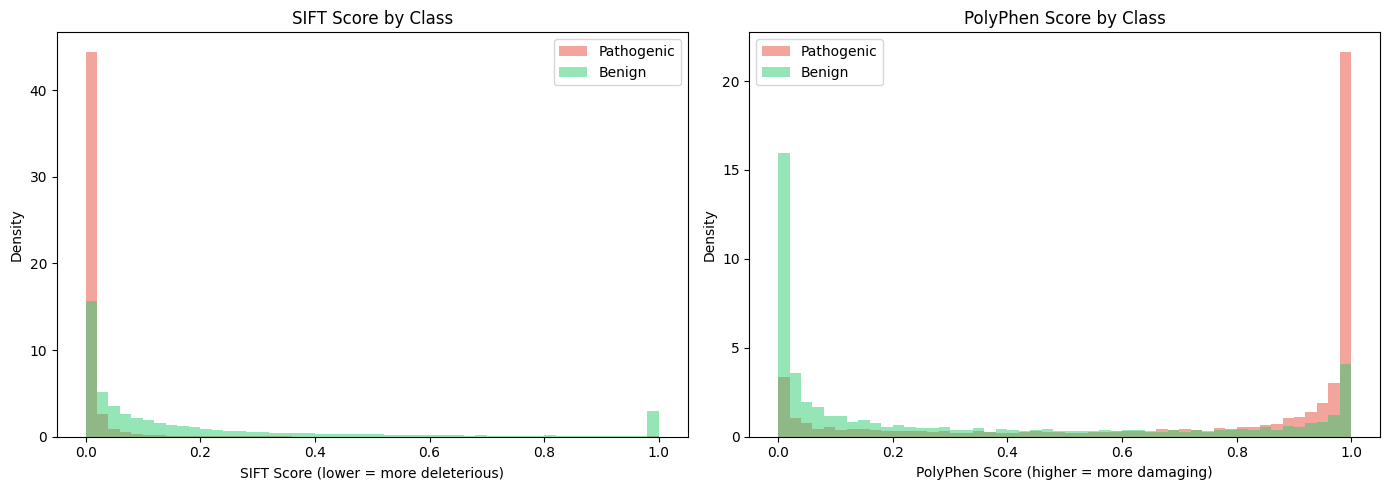

In [5]:
# SIFT / PolyPhen distribution plots
colors = {'Pathogenic': '#e74c3c', 'Benign': '#2ecc71'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for label, color in colors.items():
    subset = df_labeled[df_labeled['label'] == label]['SIFT_score_eda'].dropna()
    axes[0].hist(subset, bins=50, alpha=0.5, label=label, color=color, density=True)
axes[0].set_title('SIFT Score by Class')
axes[0].set_xlabel('SIFT Score (lower = more deleterious)')
axes[0].set_ylabel('Density')
axes[0].legend()

for label, color in colors.items():
    subset = df_labeled[df_labeled['label'] == label]['PolyPhen_score_eda'].dropna()
    axes[1].hist(subset, bins=50, alpha=0.5, label=label, color=color, density=True)
axes[1].set_title('PolyPhen Score by Class')
axes[1].set_xlabel('PolyPhen Score (higher = more damaging)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.savefig('02_sift_polyphen_distributions.png', dpi=150)
plt.show()

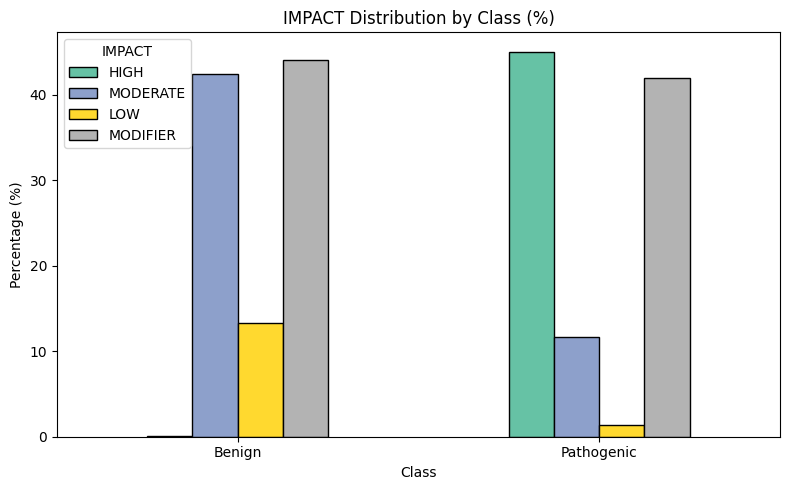

IMPACT      HIGH  MODERATE   LOW  MODIFIER
label                                     
Benign       0.1      42.5  13.3      44.1
Pathogenic  45.1      11.6   1.4      42.0


In [6]:
# IMPACT distribution by class
impact_order = ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']
impact_df  = df_labeled.groupby(['label', 'IMPACT']).size().unstack(fill_value=0)
impact_df  = impact_df.reindex(columns=impact_order, fill_value=0)
impact_pct = impact_df.div(impact_df.sum(axis=1), axis=0) * 100

impact_pct.plot(kind='bar', figsize=(8, 5), colormap='Set2', edgecolor='black')
plt.title('IMPACT Distribution by Class (%)')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='IMPACT')
plt.tight_layout()
plt.savefig('03_impact_distribution.png', dpi=150)
plt.show()
print(impact_pct.round(1))

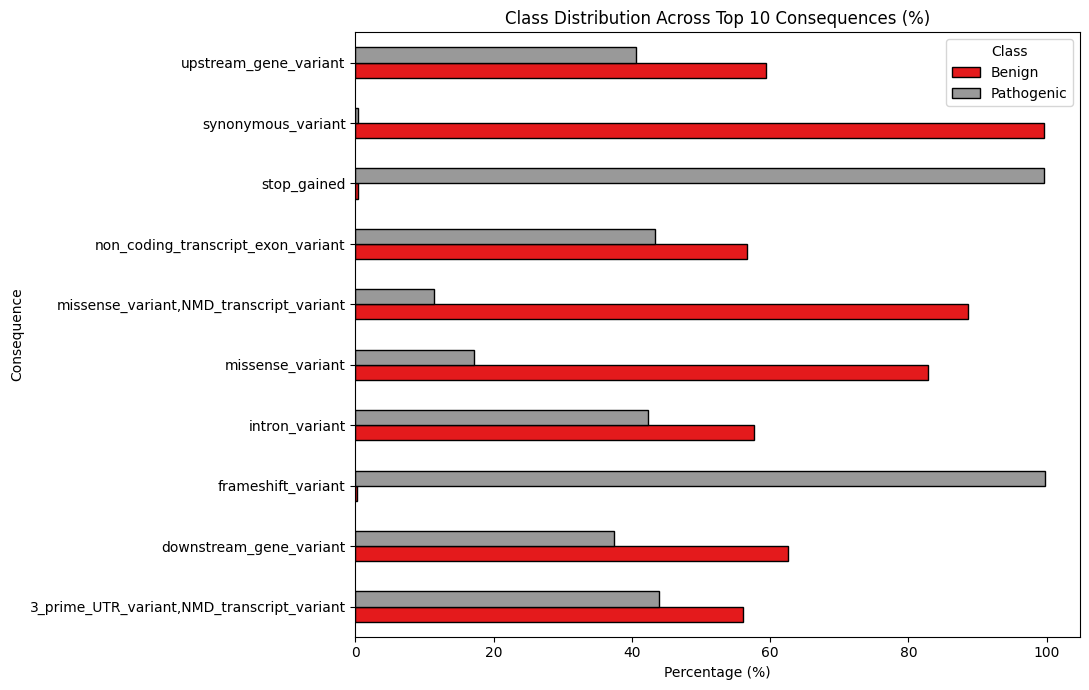

In [7]:
# Consequence distribution by class
df_labeled['Consequence_primary_eda'] = df_labeled['Consequence'].str.split('&').str[0]
top_csq = df_labeled['Consequence_primary_eda'].value_counts().head(10).index

cons_pivot = (
    df_labeled[df_labeled['Consequence_primary_eda'].isin(top_csq)]
    .groupby(['Consequence_primary_eda', 'label']).size().unstack(fill_value=0)
)
cons_pct = cons_pivot.div(cons_pivot.sum(axis=1), axis=0) * 100

cons_pct.plot(kind='barh', figsize=(11, 7), colormap='Set1', edgecolor='black')
plt.title('Class Distribution Across Top 10 Consequences (%)')
plt.xlabel('Percentage (%)')
plt.ylabel('Consequence')
plt.legend(title='Class')
plt.tight_layout()
plt.savefig('04_consequence_distribution.png', dpi=150)
plt.show()

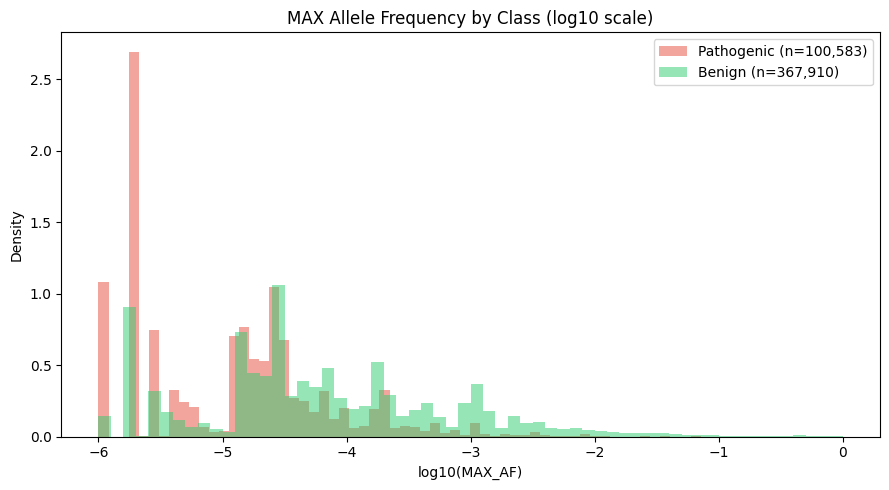

MAX_AF stats by class:
               count      mean       std  min           25%       50%  \
label                                                                   
Benign      367910.0  0.002875  0.032650  0.0  1.470000e-05  0.000045   
Pathogenic  100583.0  0.000122  0.001349  0.0  8.997000e-07  0.000015   

                 75%      max  
label                          
Benign      0.000226  1.00000  
Pathogenic  0.000030  0.07141  


In [8]:
# MAX_AF distribution by class
df_labeled['MAX_AF_eda'] = pd.to_numeric(
    df_labeled['MAX_AF'].replace('-', np.nan), errors='coerce'
)

fig, ax = plt.subplots(figsize=(9, 5))
for label, color in colors.items():
    subset = df_labeled[df_labeled['label'] == label]['MAX_AF_eda'].dropna()
    ax.hist(np.log10(subset + 1e-6), bins=60, alpha=0.5,
            label=f'{label} (n={len(subset):,})', color=color, density=True)
ax.set_title('MAX Allele Frequency by Class (log10 scale)')
ax.set_xlabel('log10(MAX_AF)')
ax.set_ylabel('Density')
ax.legend()
plt.tight_layout()
plt.savefig('05_allele_freq_distribution.png', dpi=150)
plt.show()

print("MAX_AF stats by class:")
print(df_labeled.groupby('label')['MAX_AF_eda'].describe())

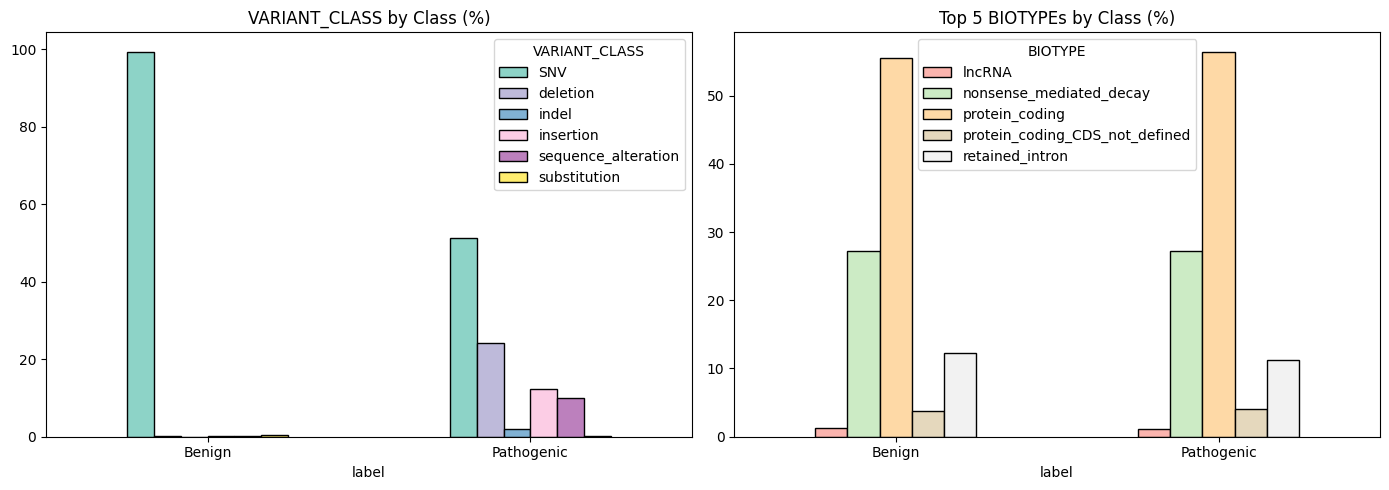

In [9]:
# VARIANT_CLASS and BIOTYPE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

vc_pivot = df_labeled.groupby(['label', 'VARIANT_CLASS']).size().unstack(fill_value=0)
vc_pct   = vc_pivot.div(vc_pivot.sum(axis=1), axis=0) * 100
vc_pct.plot(kind='bar', ax=axes[0], colormap='Set3', edgecolor='black')
axes[0].set_title('VARIANT_CLASS by Class (%)')
axes[0].tick_params(axis='x', rotation=0)

top_bio  = df_labeled['BIOTYPE'].value_counts().head(5).index
bio_pct  = (
    df_labeled[df_labeled['BIOTYPE'].isin(top_bio)]
    .groupby(['label', 'BIOTYPE']).size().unstack(fill_value=0)
    .pipe(lambda x: x.div(x.sum(axis=1), axis=0) * 100)
)
bio_pct.plot(kind='bar', ax=axes[1], colormap='Pastel1', edgecolor='black')
axes[1].set_title('Top 5 BIOTYPEs by Class (%)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('06_varclass_biotype.png', dpi=150)
plt.show()

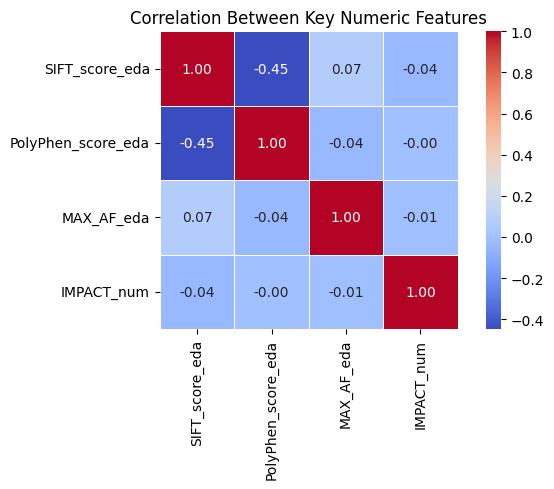

In [10]:
# Correlation heatmap
numeric_eda = df_labeled[['SIFT_score_eda', 'PolyPhen_score_eda', 'MAX_AF_eda']].copy()
numeric_eda['IMPACT_num'] = df_labeled['IMPACT'].map(
    {'HIGH': 4, 'MODERATE': 3, 'LOW': 2, 'MODIFIER': 1}
)

plt.figure(figsize=(7, 5))
sns.heatmap(numeric_eda.corr(), annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=0.5)
plt.title('Correlation Between Key Numeric Features')
plt.tight_layout()
plt.savefig('07_correlation_heatmap.png', dpi=150)
plt.show()

# Clean up EDA temp columns
df_labeled.drop(columns=['SIFT_score_eda', 'PolyPhen_score_eda',
                          'MAX_AF_eda', 'Consequence_primary_eda'], inplace=True)

## Step 3 — Feature Engineering

All feature engineering is applied to both `df_labeled` and `df_vus` using identical transformations.


In [11]:
# SIFT score + missing flag
# Compute median on labeled training data ONLY — apply to both sets
# Imputation value: 0.5 (biologically neutral) rather than a low score,
# which would incorrectly label non-missense variants as damaging.
# The SIFT_missing flag captures the fact of missingness as a separate signal.

for dset in [df_labeled, df_vus]:
    dset['SIFT_score'] = dset['SIFT'].str.extract(r'\(([\d\.]+)\)').astype(float)
    dset['SIFT_missing'] = dset['SIFT_score'].isna().astype(int)

sift_median = df_labeled['SIFT_score'].median()
print(f"SIFT median (training set): {sift_median}")
print("NOTE: Using 0.5 (neutral) for imputation instead of training median to avoid")
print("      biasing non-missense variants toward a 'damaging' score.")

SIFT_IMPUTE_VALUE = 0.5  # neutral — variants lacking SIFT are non-missense
df_labeled['SIFT_score'] = df_labeled['SIFT_score'].fillna(SIFT_IMPUTE_VALUE)
df_vus['SIFT_score']     = df_vus['SIFT_score'].fillna(SIFT_IMPUTE_VALUE)

print(f"\nSIFT_missing (labeled): {df_labeled['SIFT_missing'].value_counts().to_dict()}")
print(f"SIFT_missing (VUS):     {df_vus['SIFT_missing'].value_counts().to_dict()}")

SIFT median (training set): 0.03
NOTE: Using 0.5 (neutral) for imputation instead of training median to avoid
      biasing non-missense variants toward a 'damaging' score.

SIFT_missing (labeled): {1: 662932, 0: 271267}
SIFT_missing (VUS):     {1: 753415, 0: 702910}


In [12]:
# PolyPhen score + missing flag
# impute with 0.0 (benign/neutral) for non-missense variants

for dset in [df_labeled, df_vus]:
    dset['PolyPhen_score'] = dset['PolyPhen'].str.extract(r'\(([\d\.]+)\)').astype(float)
    dset['PolyPhen_missing'] = dset['PolyPhen_score'].isna().astype(int)

POLYPHEN_IMPUTE_VALUE = 0.0  # benign/neutral
df_labeled['PolyPhen_score'] = df_labeled['PolyPhen_score'].fillna(POLYPHEN_IMPUTE_VALUE)
df_vus['PolyPhen_score']     = df_vus['PolyPhen_score'].fillna(POLYPHEN_IMPUTE_VALUE)

print(f"PolyPhen imputed with: {POLYPHEN_IMPUTE_VALUE}")
print(f"PolyPhen_missing (labeled): {df_labeled['PolyPhen_missing'].value_counts().to_dict()}")

PolyPhen imputed with: 0.0
PolyPhen_missing (labeled): {1: 715465, 0: 218734}


In [13]:
# Allele frequency features
# Raw MAX_AF retained for interpretability but MAX_AF_log is the primary signal.

af_cols = ['MAX_AF', 'gnomADe_AF', 'gnomADg_AF']

for dset in [df_labeled, df_vus]:
    for col in af_cols:
        dset[col] = pd.to_numeric(
            dset[col].replace('-', np.nan), errors='coerce'
        ).fillna(0)
    # Missing filled with 0 = not observed in any database
    # Note: this conflates 'not in database' with 'frequency = 0'
    # — discussed in manuscript limitations
    dset['MAX_AF_log'] = np.log10(dset['MAX_AF'] + 1e-6)

print("AF columns — nulls after imputation (labeled):")
print(df_labeled[af_cols + ['MAX_AF_log']].isnull().sum())
print("\nMAX_AF_log stats (labeled):")
print(df_labeled['MAX_AF_log'].describe().round(3))

AF columns — nulls after imputation (labeled):
MAX_AF        0
gnomADe_AF    0
gnomADg_AF    0
MAX_AF_log    0
dtype: int64

MAX_AF_log stats (labeled):
count    934199.000
mean         -5.180
std           1.092
min          -6.000
25%          -6.000
50%          -6.000
75%          -4.510
max           0.000
Name: MAX_AF_log, dtype: float64


In [14]:
# IMPACT ordinal encoding
impact_map = {'HIGH': 4, 'MODERATE': 3, 'LOW': 2, 'MODIFIER': 1}

for dset in [df_labeled, df_vus]:
    dset['IMPACT_encoded'] = dset['IMPACT'].map(impact_map)

print("IMPACT encoding — nulls (labeled):", df_labeled['IMPACT_encoded'].isna().sum())
print(df_labeled[['IMPACT', 'IMPACT_encoded']].drop_duplicates().sort_values('IMPACT_encoded'))

IMPACT encoding — nulls (labeled): 0
      IMPACT  IMPACT_encoded
21  MODIFIER               1
39       LOW               2
0   MODERATE               3
55      HIGH               4


In [15]:
# BIOTYPE grouped + one-hot
# NMD (nonsense_mediated_decay) separated from protein_coding
# NMD transcripts are predicted to undergo decay and are biologically distinct.

def simplify_biotype(x):
    x = str(x)
    if x in ["protein_coding", "protein_coding_CDS_not_defined"]:
        return "protein_coding"
    elif x == "nonsense_mediated_decay":
        return "NMD"  # kept separate — biologically distinct from protein_coding
    elif x in ["lncRNA", "miRNA", "snRNA", "snoRNA", "misc_RNA"]:
        return "non_coding_RNA"
    elif "pseudogene" in x:
        return "pseudogene"
    else:
        return "other"

for dset in [df_labeled, df_vus]:
    dset['BIOTYPE_grouped'] = dset['BIOTYPE'].apply(simplify_biotype)

# One-hot encode using labeled set categories as reference
bio_categories = df_labeled['BIOTYPE_grouped'].unique().tolist()

for dset in [df_labeled, df_vus]:
    bio_dummies = pd.get_dummies(dset['BIOTYPE_grouped'], prefix='BIOTYPE')
    # Align columns to labeled set — ensures VUS has same feature schema
    for cat in bio_categories:
        col = f'BIOTYPE_{cat}'
        if col not in bio_dummies.columns:
            bio_dummies[col] = 0
    dset[bio_dummies.columns] = bio_dummies

bio_cols = [c for c in df_labeled.columns if c.startswith('BIOTYPE_') and c != 'BIOTYPE_grouped']
print("BIOTYPE grouped distribution (labeled):")
print(df_labeled['BIOTYPE_grouped'].value_counts())
print("\nBIOTYPE one-hot columns:", bio_cols)

BIOTYPE grouped distribution (labeled):
BIOTYPE_grouped
protein_coding    555827
NMD               253103
other             111041
non_coding_RNA     12197
pseudogene          2031
Name: count, dtype: int64

BIOTYPE one-hot columns: ['BIOTYPE_NMD', 'BIOTYPE_non_coding_RNA', 'BIOTYPE_other', 'BIOTYPE_protein_coding', 'BIOTYPE_pseudogene']


In [16]:
# VARIANT_CLASS grouped + one-hot
def simplify_variant_class(x):
    if x == "SNV":                          return "SNV"
    elif x in ["insertion", "deletion", "indel"]: return "INDEL"
    elif x == "substitution":               return "SUBSTITUTION"
    else:                                   return "OTHER"

for dset in [df_labeled, df_vus]:
    dset['VARIANT_CLASS_grouped'] = dset['VARIANT_CLASS'].apply(simplify_variant_class)
    vc_dummies = pd.get_dummies(dset['VARIANT_CLASS_grouped'], prefix='VARCLASS')
    dset[vc_dummies.columns] = vc_dummies

vc_cols = [c for c in df_labeled.columns if c.startswith('VARCLASS_')]
print("VARIANT_CLASS grouped (labeled):", df_labeled['VARIANT_CLASS_grouped'].value_counts().to_dict())
print("VARCLASS one-hot columns:", vc_cols)

VARIANT_CLASS grouped (labeled): {'SNV': 732534, 'INDEL': 158031, 'OTHER': 40840, 'SUBSTITUTION': 2794}
VARCLASS one-hot columns: ['VARCLASS_INDEL', 'VARCLASS_OTHER', 'VARCLASS_SNV', 'VARCLASS_SUBSTITUTION']


In [17]:
# MANE and APPRIS binary flags
for dset in [df_labeled, df_vus]:
    dset['MANE_flag']   = dset['MANE_SELECT'].apply(lambda x: 0 if str(x) == '-' else 1)
    dset['APPRIS_flag'] = dset['APPRIS'].apply(lambda x: 0 if str(x) == '-' else 1)

print("MANE_flag (labeled):  ", df_labeled['MANE_flag'].value_counts().to_dict())
print("APPRIS_flag (labeled):", df_labeled['APPRIS_flag'].value_counts().to_dict())

MANE_flag (labeled):   {0: 886387, 1: 47812}
APPRIS_flag (labeled): {0: 733221, 1: 200978}


In [18]:
# Consequence: primary term (most severe) + one-hot
# VEP orders multiple consequences by severity, separated by '&'.
# Splitting on '&' and taking [0] gives the most severe consequence.

for dset in [df_labeled, df_vus]:
    dset['Consequence_primary'] = dset['Consequence'].str.split('&').str[0]

top_csq = df_labeled['Consequence_primary'].value_counts().head(15).index.tolist()

for dset in [df_labeled, df_vus]:
    dset['Consequence_grouped'] = dset['Consequence_primary'].apply(
        lambda x: x if x in top_csq else 'other'
    )
    csq_dummies = pd.get_dummies(dset['Consequence_grouped'], prefix='CSQ')

    for csq in top_csq + ['other']:
        col = f'CSQ_{csq}'
        if col not in csq_dummies.columns:
            csq_dummies[col] = 0
    dset[csq_dummies.columns] = csq_dummies

csq_cols = [c for c in df_labeled.columns if c.startswith('CSQ_')]
print("Consequence one-hot columns:", csq_cols)
print("Total CSQ columns:", len(csq_cols))
print("Nulls in CSQ columns:", df_labeled[csq_cols].isnull().sum().sum())

Consequence one-hot columns: ['CSQ_3_prime_UTR_variant,NMD_transcript_variant', 'CSQ_5_prime_UTR_variant', 'CSQ_downstream_gene_variant', 'CSQ_frameshift_variant', 'CSQ_frameshift_variant,NMD_transcript_variant', 'CSQ_intron_variant', 'CSQ_intron_variant,NMD_transcript_variant', 'CSQ_missense_variant', 'CSQ_missense_variant,NMD_transcript_variant', 'CSQ_non_coding_transcript_exon_variant', 'CSQ_other', 'CSQ_stop_gained', 'CSQ_stop_gained,NMD_transcript_variant', 'CSQ_synonymous_variant', 'CSQ_synonymous_variant,NMD_transcript_variant', 'CSQ_upstream_gene_variant']
Total CSQ columns: 16
Nulls in CSQ columns: 0


## Step 4 — Feature Matrix Assembly & Train/Test Split

The train/test split is performed by variant ID using `GroupShuffleSplit`.
This guarantees all transcript rows belonging to the same variant stay within the same split,
preventing any form of transcript-level data leakage.

In [19]:
from sklearn.model_selection import GroupShuffleSplit

bio_cols = [c for c in df_labeled.columns if c.startswith('BIOTYPE_') and c != 'BIOTYPE_grouped']
vc_cols  = [c for c in df_labeled.columns if c.startswith('VARCLASS_')]
csq_cols = [c for c in df_labeled.columns if c.startswith('CSQ_')]

feature_cols = (
    ['SIFT_score', 'SIFT_missing',
     'PolyPhen_score', 'PolyPhen_missing',
     'IMPACT_encoded',
     'MAX_AF_log',          # primary AF feature (log-transformed)
     'gnomADe_AF',          # exome cohort AF
     'gnomADg_AF',          # genome cohort AF
     # Population-stratified AFs excluded — highly correlated with MAX_AF
     'MANE_flag', 'APPRIS_flag']
    + csq_cols + bio_cols + vc_cols
)

X = df_labeled[feature_cols]
y = df_labeled['label']
groups = df_labeled['Uploaded_variation']   # group key = variant ID

# ── Variant-level GroupShuffleSplit 
# Splitting by groups ensures ALL transcript rows of a variant
# land in the same fold — no leakage across transcripts.
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Sanity check — no variant should appear in both train and test
train_variants = set(groups.iloc[train_idx])
test_variants  = set(groups.iloc[test_idx])
overlap = train_variants & test_variants
print(f"Variant overlap between train and test: {len(overlap)} (should be 0)")

print(f"\nTotal transcript rows : {len(X):,}")
print(f"  Train rows : {len(X_train):,}  |  unique variants: {len(train_variants):,}")
print(f"  Test rows  : {len(X_test):,}   |  unique variants: {len(test_variants):,}")
print(f"\nLabel distribution — Train:")
print(y_train.value_counts())
print(f"\nLabel distribution — Test:")
print(y_test.value_counts())

# VUS feature matrix (inference)
X_vus = df_vus[feature_cols]
print(f"\nVUS inference matrix : {X_vus.shape}")
print(f"Null check (train)   : {X_train.isnull().sum().sum()}")
print(f"Null check (test)    : {X_test.isnull().sum().sum()}")
print(f"Null check (VUS)     : {X_vus.isnull().sum().sum()}")

Variant overlap between train and test: 0 (should be 0)

Total transcript rows : 934,199
  Train rows : 747,817  |  unique variants: 28,798
  Test rows  : 186,382   |  unique variants: 7,200

Label distribution — Train:
label
Benign        422007
Pathogenic    325810
Name: count, dtype: int64

Label distribution — Test:
label
Benign        105644
Pathogenic     80738
Name: count, dtype: int64

VUS inference matrix : (1456325, 35)
Null check (train)   : 0
Null check (test)    : 0
Null check (VUS)     : 0


## Step 5 — Save Checkpoints

In [20]:
# Save labeled data with train/test index split info
df_labeled['split'] = 'train'
df_labeled.iloc[test_idx, df_labeled.columns.get_loc('split')] = 'test'

df_labeled.to_parquet("checkpoint_labeled.parquet", index=False)
df_vus.to_parquet("checkpoint_vus_inference.parquet", index=False)

# Save train/test indices
import numpy as np
np.save("train_idx.npy", train_idx)
np.save("test_idx.npy",  test_idx)

# Save feature column list
with open("feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

# Save imputation constants
imputation_constants = {
    "SIFT_impute": SIFT_IMPUTE_VALUE,
    "PolyPhen_impute": POLYPHEN_IMPUTE_VALUE,
    "AF_impute": 0,
    "AF_log_floor": -6.0,
    "split_note": "GroupShuffleSplit on Uploaded_variation — all transcripts of a variant in same split"
}
with open("imputation_constants.json", "w") as f:
    json.dump(imputation_constants, f)

print(" checkpoint_labeled.parquet       :", df_labeled.shape)
print(" checkpoint_vus_inference.parquet :", df_vus.shape)
print(" train_idx.npy / test_idx.npy")
print(" feature_cols.json               :", len(feature_cols), "features")
print(" imputation_constants.json       :", imputation_constants)

 checkpoint_labeled.parquet       : (934199, 118)
 checkpoint_vus_inference.parquet : (1456325, 117)
 train_idx.npy / test_idx.npy
 feature_cols.json               : 35 features
 imputation_constants.json       : {'SIFT_impute': 0.5, 'PolyPhen_impute': 0.0, 'AF_impute': 0, 'AF_log_floor': -6.0, 'split_note': 'GroupShuffleSplit on Uploaded_variation — all transcripts of a variant in same split'}
